# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import accuracy_score, roc_auc_score

In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              303 non-null    float64 
 1   sex              303 non-null    float64 
 2   cp               303 non-null    float64 
 3   trestbps         303 non-null    float64 
 4   chol             303 non-null    float64 
 5   fbs              303 non-null    float64 
 6   restecg          303 non-null    float64 
 7   thalach          303 non-null    float64 
 8   exang            303 non-null    float64 
 9   oldpeak          303 non-null    float64 
 10  slope            303 non-null    float64 
 11  ca               303 non-null    object  
 12  thal             303 non-null    object  
 13  num              303 non-null    int64   
 14  flag_doente      303 non-null    int64   
 15  age_cat          303 non-null    category
 16  const            303 non-null    int64   
 1

1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [24]:
# Função para realizar a análise bivariada
def bivariate_analysis(df, response_var, explanatory_var):
    # Calcula a média da variável resposta para cada nível da variável explicativa
    bivariate_df = df.groupby(explanatory_var)[response_var].mean().reset_index()
    bivariate_df.columns = [explanatory_var, f'Média de {response_var}']
    return bivariate_df

# Aplicando a função a três variáveis qualitativas
variaveis_qualitativas = ['sex', 'cp', 'fbs']

for var in variaveis_qualitativas:
    print(f'\nAnálise bivariada para: {var}')
    result = bivariate_analysis(df, 'flag_doente', var)
    print(result)


Análise bivariada para: sex
   sex  Média de flag_doente
0  0.0              0.257732
1  1.0              0.553398

Análise bivariada para: cp
    cp  Média de flag_doente
0  1.0              0.304348
1  2.0              0.180000
2  3.0              0.209302
3  4.0              0.729167

Análise bivariada para: fbs
   fbs  Média de flag_doente
0  0.0              0.453488
1  1.0              0.488889


2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [27]:
# Função para categorizar variáveis contínuas e realizar análise bivariada
def continuous_bivariate_analysis(df, response_var, explanatory_var, num_groups=5):
    # Categoriza a variável explicativa em 'num_groups' intervalos
    df[f'{explanatory_var}_cat'] = pd.cut(df[explanatory_var], bins=num_groups)
    
    # Calcula a média da variável resposta para cada categoria
    bivariate_df = df.groupby(f'{explanatory_var}_cat', observed=False)[response_var].mean().reset_index()
    bivariate_df.columns = [f'{explanatory_var}_categoria', f'Média de {response_var}']
    
    return bivariate_df

# Aplicando a função à variável 'age'
result = continuous_bivariate_analysis(df, 'flag_doente', 'age', num_groups=5)
print(result)


    age_categoria  Média de flag_doente
0  (28.952, 38.6]              0.272727
1    (38.6, 48.2]              0.295775
2    (48.2, 57.8]              0.422680
3    (57.8, 67.4]              0.626168
4    (67.4, 77.0]              0.411765


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [30]:
# Definindo as variáveis explicativas e a variável resposta
# Usaremos 'age', 'sex', 'cp', e 'trestbps' como variáveis explicativas
# E 'flag_doente' como variável resposta (target)

# Adicionando uma constante para o intercepto do modelo
df['const'] = 1

# Definindo o modelo com as variáveis qualitativas e quantitativa
logit_model = sm.Logit(df['flag_doente'], df[['const', 'age', 'sex', 'cp', 'trestbps']])

# Ajustando o modelo
result = logit_model.fit()

# Exibindo o resumo do modelo
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      298
Method:                           MLE   Df Model:                            4
Date:                Fri, 11 Oct 2024   Pseudo R-squ.:                  0.2605
Time:                        03:34:04   Log-Likelihood:                -154.55
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.264e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.1167      1.608     -6.915      0.000     -14.267      -7.966
age            0.0582      0.

Constante (-11.1167):

É o log-odds quando todas as variáveis explicativas são zero. Neste caso, não tem uma interpretação prática direta, pois não faz sentido ter uma idade de 0, sexo indefinido ou pressão arterial de 0.

Idade (0.0582):

Para cada ano adicional de idade, o log-odds de ter a doença cardíaca aumenta em 0.0582, mantendo as outras variáveis constantes. Isso sugere que pessoas mais velhas têm maior risco de doença cardíaca. O valor p (0.001) indica que essa relação é estatisticamente significativa.

Sexo (1.8021):

Se o paciente é do sexo masculino (1) em comparação com feminino (0), o log-odds de ter a doença cardíaca aumenta em 1.8021. Isso significa que os homens têm um risco significativamente maior de doença cardíaca em comparação com as mulheres. O valor p (0.000) confirma a significância estatística.

Dor no peito (cp) (1.1403):

O tipo de dor no peito está positivamente associado à presença da doença. Para cada aumento em cp, o log-odds de ter a doença aumenta em 1.1403. O valor p (0.000) também indica que essa variável é significativa.

Pressão arterial em repouso (trestbps) (0.0214):

Para cada mm Hg adicional na pressão arterial em repouso, o log-odds de ter a doença cardíaca aumenta em 0.0214, mantendo as outras variáveis constantes. Este resultado é também estatisticamente significativo (p = 0.009).

Todos os preditores no modelo são estatisticamente significativos e mostram uma associação positiva com a presença de doença cardíaca, especialmente sex, cp, e age, que são os mais impactantes. O modelo sugere que, ao considerar a idade, o sexo e o tipo de dor no peito, junto com a pressão arterial, é possível prever o risco de doença cardíaca de maneira efetiva.

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

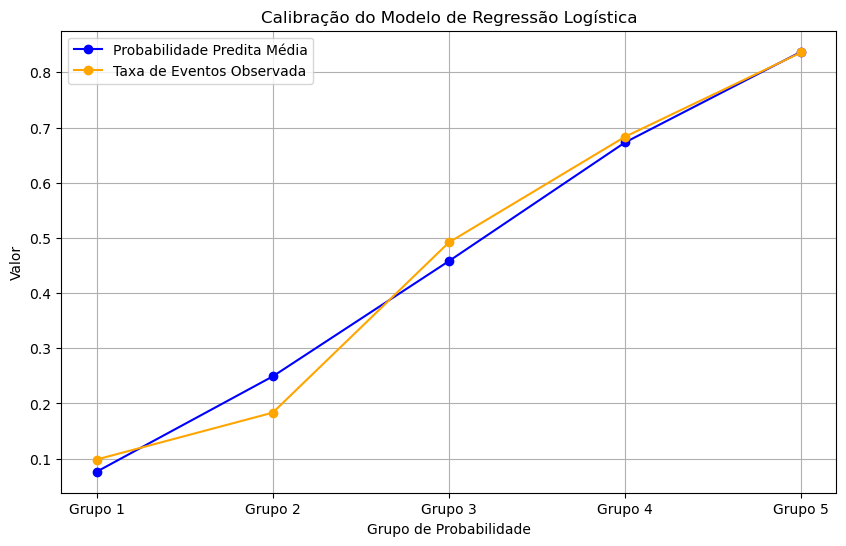

   prob_group  mean_predicted_prob  event_rate
0           0             0.076255    0.098361
1           1             0.249060    0.183333
2           2             0.457982    0.491803
3           3             0.673059    0.683333
4           4             0.837449    0.836066


In [35]:
# Supondo que o modelo já foi ajustado e temos 'result' do modelo

# 1. Calcular a probabilidade predita
df['predicted_prob'] = result.predict(df[['const', 'age', 'sex', 'cp', 'trestbps']])

# 2. Categorizar a probabilidade em 5 grupos
df['prob_group'] = pd.qcut(df['predicted_prob'], q=5, labels=False)

# 3. Calcular a probabilidade média e a taxa de eventos por grupo
grouped = df.groupby('prob_group').agg(
    mean_predicted_prob=('predicted_prob', 'mean'),
    event_rate=('flag_doente', 'mean')
).reset_index()

# 4. Comparar graficamente os valores esperados (média predita) versus observados (taxa de eventos)
plt.figure(figsize=(10, 6))
plt.plot(grouped['prob_group'], grouped['mean_predicted_prob'], marker='o', label='Probabilidade Predita Média', color='blue')
plt.plot(grouped['prob_group'], grouped['event_rate'], marker='o', label='Taxa de Eventos Observada', color='orange')

plt.title('Calibração do Modelo de Regressão Logística')
plt.xlabel('Grupo de Probabilidade')
plt.ylabel('Valor')
plt.xticks(ticks=grouped['prob_group'], labels=[f'Grupo {i+1}' for i in range(5)])
plt.legend()
plt.grid()
plt.show()

# Exibir os resultados agrupados
print(grouped)


5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

Acurácia: 0.7789
GINI: 0.6622
Valor KS: 0.4968


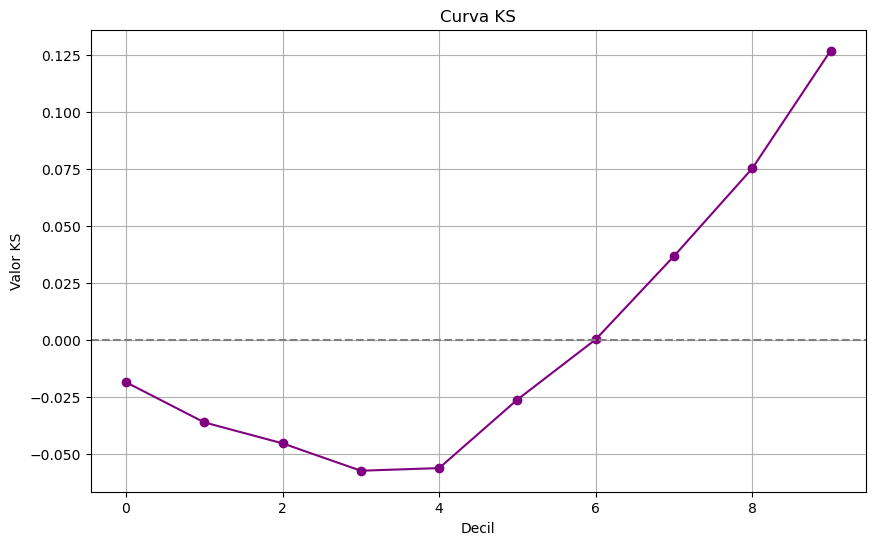

   decile        ks
0       0 -0.018492
1       1 -0.036115
2       2 -0.045321
3       3 -0.057332
4       4 -0.056181
5       5 -0.026102
6       6  0.000303
7       7  0.036862
8       8  0.075359
9       9  0.127019


In [44]:
# Supondo que o modelo já foi ajustado e temos 'result' do modelo

# 1. Calcular a probabilidade predita
df['predicted_prob'] = result.predict(df[['const', 'age', 'sex', 'cp', 'trestbps']])

# Definindo um limite de decisão
threshold = 0.5
df['predicted_class'] = (df['predicted_prob'] >= threshold).astype(int)

# 2. Calcular a Acurácia
accuracy = accuracy_score(df['flag_doente'], df['predicted_class'])
print(f"Acurácia: {accuracy:.4f}")

# 3. Calcular o GINI
# AUC é a área sob a curva ROC
auc = roc_auc_score(df['flag_doente'], df['predicted_prob'])
gini = 2 * auc - 1
print(f"GINI: {gini:.4f}")

# 4. Calcular o KS
# Agrupar as previsões
ks_table = df.groupby('predicted_class')['predicted_prob'].agg(['count', 'mean']).reset_index()
ks_value = ks_table['mean'].diff().abs().max()
print(f"Valor KS: {ks_value:.4f}")

# Abaixo está um código para visualizar a curva KS
ks_data = df[['predicted_prob', 'flag_doente']].copy()
ks_data['decile'] = pd.qcut(ks_data['predicted_prob'], 10, labels=False)

ks_summary = ks_data.groupby('decile').agg(
    total_count=('flag_doente', 'count'),
    event_count=('flag_doente', 'sum')
).reset_index()

ks_summary['non_event_count'] = ks_summary['total_count'] - ks_summary['event_count']
ks_summary['cumulative_events'] = ks_summary['event_count'].cumsum()
ks_summary['cumulative_non_events'] = ks_summary['non_event_count'].cumsum()
ks_summary['ks'] = (ks_summary['cumulative_events'] / ks_summary['cumulative_events'].sum()) - (ks_summary['cumulative_non_events'] / ks_summary['cumulative_non_events'].sum())

# Plotando a curva KS
plt.figure(figsize=(10, 6))
plt.plot(ks_summary['decile'], ks_summary['ks'], marker='o', color='purple')
plt.axhline(0, color='grey', linestyle='--')
plt.title('Curva KS')
plt.xlabel('Decil')
plt.ylabel('Valor KS')
plt.grid()
plt.show()

# Exibir os resultados
print(ks_summary[['decile', 'ks']])


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

Optimization terminated successfully.
         Current function value: 0.421426
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      294
Method:                           MLE   Df Model:                            8
Date:                Fri, 11 Oct 2024   Pseudo R-squ.:                  0.3890
Time:                        03:38:00   Log-Likelihood:                -127.69
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 4.577e-31
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.3753      2.338     -2.727      0.006     -10.958      -1.792
age            0.0233      0.

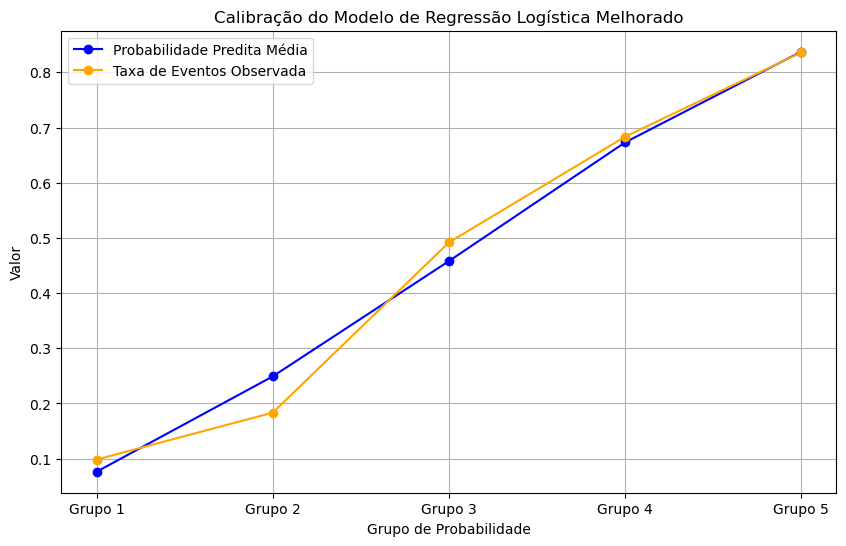

In [48]:
# Vamos incluir mais variáveis no modelo
model_formula = 'flag_doente ~ age + sex + cp + trestbps + chol + thalach + oldpeak + exang'

# Ajustando o modelo com as novas variáveis
result_improved = smf.logit(formula=model_formula, data=df).fit()

# Exibir os resultados do novo modelo
print(result_improved.summary())

# 1. Calcular a probabilidade predita
df['predicted_prob_improved'] = result_improved.predict(df[['const', 'age', 'sex', 'cp', 'trestbps', 'chol', 'thalach', 'oldpeak', 'exang']])

# Definindo um novo limite de decisão
df['predicted_class_improved'] = (df['predicted_prob_improved'] >= threshold).astype(int)

# 2. Calcular a Acurácia
accuracy_improved = accuracy_score(df['flag_doente'], df['predicted_class_improved'])
print(f"Acurácia Melhorada: {accuracy_improved:.4f}")

# 3. Calcular o GINI
auc_improved = roc_auc_score(df['flag_doente'], df['predicted_prob_improved'])
gini_improved = 2 * auc_improved - 1
print(f"GINI Melhorado: {gini_improved:.4f}")

# 4. Calcular o KS
ks_table_improved = df.groupby('predicted_class_improved')['predicted_prob_improved'].agg(['count', 'mean']).reset_index()
ks_value_improved = ks_table_improved['mean'].diff().abs().max()
print(f"Valor KS Melhorado: {ks_value_improved:.4f}")

# Comparação Gráfica (similar ao que você fez anteriormente)
plt.figure(figsize=(10, 6))
plt.plot(grouped['prob_group'], grouped['mean_predicted_prob'], marker='o', label='Probabilidade Predita Média', color='blue')
plt.plot(grouped['prob_group'], grouped['event_rate'], marker='o', label='Taxa de Eventos Observada', color='orange')

plt.title('Calibração do Modelo de Regressão Logística Melhorado')
plt.xlabel('Grupo de Probabilidade')
plt.ylabel('Valor')
plt.xticks(ticks=grouped['prob_group'], labels=[f'Grupo {i+1}' for i in range(5)])
plt.legend()
plt.grid()
plt.show()
